# mini project -  methods for detecting attacks

## enviroment setup

## imports

In [1]:
from collections import Counter, OrderedDict

import statistics

import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from itertools import combinations

import seaborn as sns

from google.colab import drive

*verifying* GPU

In [ ]:
print(tf.test.gpu_device_name())

## data loading

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data_all = pd.read_csv('/content/drive/MyDrive/' + 'IoT Network Intrusion Dataset' '.csv')

In [4]:
len(data_all)

625783

In [ ]:
data_all.head()

,Flow_ID,Src_IP,Src_Port,Dst_IP,Dst_Port,Protocol,Timestamp,Flow_Duration,Tot_Fwd_Pkts,Tot_Bwd_Pkts,...,Active_Std,Active_Max,Active_Min,Idle_Mean,Idle_Std,Idle_Max,Idle_Min,Label,Cat,Sub_Cat
0,192.168.0.13-192.168.0.16-10000-10101-17,192.168.0.13,10000,192.168.0.16,10101,17,25/07/2019 03:25:53 AM,75,1,1,...,0.0,0.0,0.0,75.0,0.000000,75.0,75.0,Anomaly,Mirai,Mirai-Ackflooding
1,192.168.0.13-222.160.179.132-554-2179-6,222.160.179.132,2179,192.168.0.13,554,6,26/05/2019 10:11:06 PM,5310,1,2,...,0.0,0.0,0.0,2655.0,2261.327486,4254.0,1056.0,Anomaly,DoS,DoS-Synflooding
2,192.168.0.13-192.168.0.16-9020-52727-6,192.168.0.16,52727,192.168.0.13,9020,6,11/07/2019 01:24:48 AM,141,0,3,...,0.0,0.0,0.0,70.5,0.707107,71.0,70.0,Anomaly,Scan,Scan Port OS
3,192.168.0.13-192.168.0.16-9020-52964-6,192.168.0.16,52964,192.168.0.13,9020,6,04/09/2019 03:58:17 AM,151,0,2,...,0.0,0.0,0.0,151.0,0.000000,151.0,151.0,Anomaly,Mirai,Mirai-Hostbruteforceg
4,192.168.0.1-239.255.255.250-36763-1900-17,192.168.0.1,36763,239.255.255.250,1900,17,10/09/2019 01:41:18 AM,153,2,1,...,0.0,0.0,0.0,76.5,0.707107,77.0,76.0,Anomaly,Mirai,Mirai-Hostbruteforceg


## removing non-anomolies

In [5]:
data = data_all.loc[data_all['Label'] != 'Anomaly']

let see with how much data we lerft with :

In [ ]:
len(data)

40073

we will no try to train a dummy clasifier, to find the dataset's base accurcy, by tryin to predict the src IP

In [ ]:
srcIP = data['Src_IP']

In [ ]:
model_data = data.drop('Src_IP', axis=1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(model_data, srcIP, test_size=0.2)

In [ ]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)

DummyClassifier(strategy='most_frequent')

In [ ]:
predictions = dummy_clf.predict(X_test)

In [ ]:
accuracy_score(predictions, y_test)

0.785402370555209

## anylsis of all data

In [34]:
data_all_anylsis = data_all.drop(columns=['Flow_ID', 'Src_IP', 'Src_Port', 'Dst_IP', 'Dst_Port', 'Protocol', 'Timestamp', 'Label', 'Cat'])
data_all_anylsis.replace([np.inf, -np.inf], np.nan, inplace=True)

In [35]:
categories = list(Counter(data_all['Sub_Cat']).keys())
categories

['Mirai-Ackflooding',
 'DoS-Synflooding',
 'Scan Port OS',
 'Mirai-Hostbruteforceg',
 'Mirai-UDP Flooding',
 'Mirai-HTTP Flooding',
 'Normal',
 'Scan Hostport',
 'MITM ARP Spoofing']

In [57]:
def getCategoryRecords(cat):
  ans = data_all_anylsis[data_all_anylsis['Sub_Cat'] == cat]
  ans = ans.drop(columns=['Sub_Cat'])
  print(f'{cat} records : {len(ans)}')
  return ans

def getSimilarity(data1, data2, SIMILARITY_THRESHOLD = 0.98) :
  data1 = data1.mean()
  data2 = data2.mean()

  columns = ['field', 'HTTP AVG', 'ACK AVG', 'similarity']
  ans = pd.DataFrame(columns=columns)
  rows = []
  zeros = 0

  for k, v in data1.items():
    if v == data2[k] :
      rows.append([k, data2[k], v, 1])
      if v == 0 :
        zeros +=1
      continue

    if v == 0 or data2[k] == 0:
        continue


    diff = min( data2[k]/v, v/data2[k])

    if diff <= 1 and diff >= SIMILARITY_THRESHOLD:
      rows.append([k, data2[k], v, diff])

  ans = pd.concat([ans, pd.DataFrame(rows, columns=columns)], ignore_index=True)
  print(f'#zero equal features: {zeros}')
  print(f'#similar features: {len(ans)}\n')
  return ans

In [58]:
columns = ['category 1', 'category 2', 'similarFeatures']
similarityHeatMap = pd.DataFrame(columns=columns)
rows = []

for cat1, cat2 in combinations(categories,2) :
  similarFeatures = getSimilarity(getCategoryRecords(cat1), getCategoryRecords(cat2))
  rows.append([cat1, cat2, len(similarFeatures)])
  rows.append([cat2, cat1, len(similarFeatures)])

for cat in categories :
  rows.append([cat, cat,  len(data_all_anylsis.columns) - 1]) # -1 for the

similarityHeatMap = pd.concat([similarityHeatMap, pd.DataFrame(rows, columns=columns)], ignore_index=True)

Mirai-Ackflooding records : 55124
DoS-Synflooding records : 59391
#zero equal features: 9
#similar features: 10

Mirai-Ackflooding records : 55124
Scan Port OS records : 53073
#zero equal features: 13
#similar features: 15

Mirai-Ackflooding records : 55124
Mirai-Hostbruteforceg records : 121181
#zero equal features: 10
#similar features: 11

Mirai-Ackflooding records : 55124
Mirai-UDP Flooding records : 183554
#zero equal features: 9
#similar features: 10

Mirai-Ackflooding records : 55124
Mirai-HTTP Flooding records : 55818
#zero equal features: 13
#similar features: 72

Mirai-Ackflooding records : 55124
Normal records : 40073
#zero equal features: 13
#similar features: 17

Mirai-Ackflooding records : 55124
Scan Hostport records : 22192
#zero equal features: 13
#similar features: 16

Mirai-Ackflooding records : 55124
MITM ARP Spoofing records : 35377
#zero equal features: 13
#similar features: 14

DoS-Synflooding records : 59391
Scan Port OS records : 53073
#zero equal features: 9
#s

In [59]:
similarityHeatMap['similarFeatures'] = pd.to_numeric(similarityHeatMap['similarFeatures'] / similarityHeatMap['similarFeatures'].max() )
similarityHeatMap = similarityHeatMap.pivot(index='category 1', columns='category 2', values='similarFeatures')

In [60]:
similarityHeatMap

category 2,DoS-Synflooding,MITM ARP Spoofing,Mirai-Ackflooding,Mirai-HTTP Flooding,Mirai-Hostbruteforceg,Mirai-UDP Flooding,Normal,Scan Hostport,Scan Port OS
category 1,,,,,,,,,
DoS-Synflooding,1.000000,0.157895,0.131579,0.131579,0.157895,0.131579,0.131579,0.131579,0.131579
MITM ARP Spoofing,0.157895,1.000000,0.184211,0.184211,0.223684,0.131579,0.184211,0.342105,0.394737
Mirai-Ackflooding,0.131579,0.184211,1.000000,0.947368,0.144737,0.131579,0.223684,0.210526,0.197368
Mirai-HTTP Flooding,0.131579,0.184211,0.947368,1.000000,0.144737,0.131579,0.223684,0.210526,0.197368
Mirai-Hostbruteforceg,0.157895,0.223684,0.144737,0.144737,1.000000,0.144737,0.157895,0.144737,0.236842
Mirai-UDP Flooding,0.131579,0.131579,0.131579,0.131579,0.144737,1.000000,0.131579,0.131579,0.144737
Normal,0.131579,0.184211,0.223684,0.223684,0.157895,0.131579,1.000000,0.236842,0.250000
Scan Hostport,0.131579,0.342105,0.210526,0.210526,0.144737,0.131579,0.236842,1.000000,0.381579
Scan Port OS,0.131579,0.394737,0.197368,0.197368,0.236842,0.144737,0.250000,0.381579,1.000000


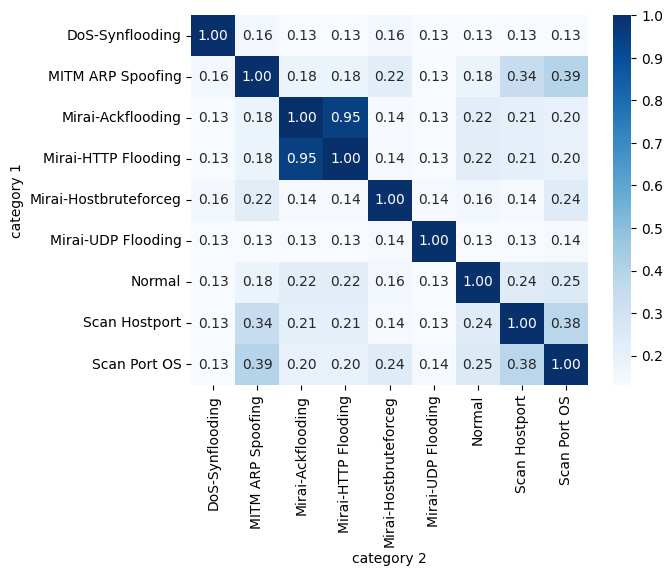

In [61]:
map = sns.heatmap(similarityHeatMap, annot=True, cmap='Blues', fmt=".2f")

In [62]:
fig = map.get_figure()
fig.savefig('heatmap.pdf', format='pdf', bbox_inches='tight')

## Data analysis

In [ ]:
def numOfUnique(row):
  return len(set(row))

def countAppearances(row):
  return Counter(row)

def drawDistributionGraph(row, field, show=True):
  appearances = countAppearances(row).values()


  plt.title(f'{field} distribution')
  plt.ylabel('amout of entries')
  plt.xlabel('amout of appearances')

  info_text = '\n'.join((
    r'$std=%.3f$' % (statistics.stdev(appearances), ),
    r'$mean=%.3f$' % (statistics.mean(appearances), )))

  n, bins, patches = plt.hist(appearances)

  plt.text(plt.xlim()[1] * .95, plt.ylim()[1] * .95, info_text, ha='right', va='top', bbox=dict(facecolor='white', alpha=0.8))
  if show :
    plt.show()

let see how many diffrent IP adresses we have

In [ ]:
numOfUnique(data['Src_IP'])

38

ket check how many accurence tere is for each IP

In [ ]:
countAppearances(data['Src_IP']).most_common()

[('192.168.0.13', 31483),
 ('192.168.0.16', 4342),
 ('192.168.0.24', 1950),
 ('192.168.0.1', 1712),
 ('192.168.0.23', 194),
 ('211.233.18.24', 121),
 ('223.39.118.176', 58),
 ('180.182.59.219', 38),
 ('223.39.123.191', 35),
 ('223.39.123.194', 23),
 ('104.76.84.32', 17),
 ('192.168.0.14', 11),
 ('172.217.25.99', 9),
 ('14.129.200.42', 9),
 ('216.58.197.206', 8),
 ('18.136.162.179', 8),
 ('54.180.57.16', 7),
 ('17.248.161.108', 6),
 ('17.252.141.84', 6),
 ('23.23.161.173', 5),
 ('108.177.97.189', 4),
 ('108.177.125.188', 3),
 ('134.221.96.8', 3),
 ('104.75.19.88', 3),
 ('211.188.204.21', 3),
 ('134.221.96.11', 2),
 ('134.221.96.0', 2),
 ('134.221.96.9', 1),
 ('198.252.206.25', 1),
 ('179.152.102.161', 1),
 ('23.23.130.219', 1),
 ('203.205.142.177', 1),
 ('50.16.236.62', 1),
 ('74.125.203.189', 1),
 ('8.6.0.1', 1),
 ('172.217.161.42', 1),
 ('172.217.25.110', 1),
 ('172.217.26.37', 1)]

let see the distribution graph for src IP

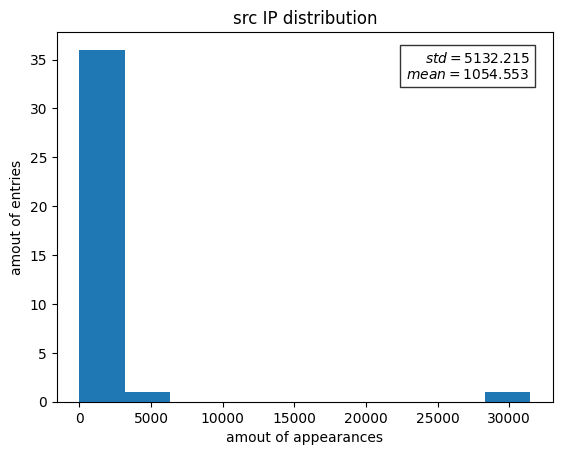

In [ ]:
drawDistributionGraph(data['Src_IP'], 'src IP')

let do the same on dst IP

In [ ]:
numOfUnique(data['Dst_IP'])

45

In [ ]:
countAppearances(data['Dst_IP']).most_common()

[('192.168.0.16', 31491),
 ('192.168.0.13', 4267),
 ('192.168.0.14', 1680),
 ('104.70.122.58', 1201),
 ('192.168.0.23', 255),
 ('222.239.240.107', 234),
 ('223.39.118.176', 212),
 ('223.39.123.245', 145),
 ('223.39.123.191', 85),
 ('211.188.147.64', 70),
 ('192.168.0.24', 63),
 ('239.255.255.250', 60),
 ('13.32.255.250', 50),
 ('104.76.84.32', 49),
 ('18.136.162.179', 36),
 ('224.0.0.251', 35),
 ('223.39.123.193', 26),
 ('224.0.0.1', 12),
 ('13.228.245.106', 11),
 ('14.129.200.42', 10),
 ('223.39.118.149', 10),
 ('210.103.251.72', 9),
 ('13.209.102.114', 7),
 ('211.188.204.21', 6),
 ('192.168.0.1', 5),
 ('23.23.161.173', 5),
 ('23.23.254.24', 4),
 ('50.16.236.62', 4),
 ('52.85.124.41', 4),
 ('179.77.0.91', 3),
 ('172.217.25.110', 3),
 ('172.217.26.2', 3),
 ('82.231.1.105', 2),
 ('0.0.0.16', 2),
 ('50.16.244.244', 2),
 ('203.217.239.46', 2),
 ('54.243.33.91', 2),
 ('121.157.1.2', 1),
 ('31.237.26.217', 1),
 ('172.217.161.42', 1),
 ('203.205.142.177', 1),
 ('23.23.130.219', 1),
 ('52.78.

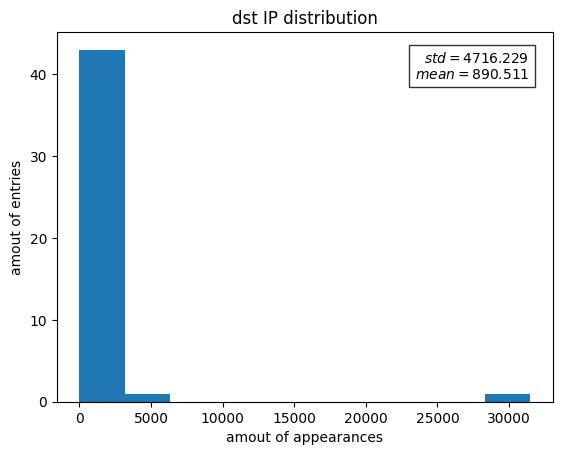

In [ ]:
drawDistributionGraph(data['Dst_IP'], 'dst IP')

let see how many protocols were in use

In [ ]:
numOfUnique(data['Protocol'])

3

let look on the distribution graphs of total amount of package sent, and received

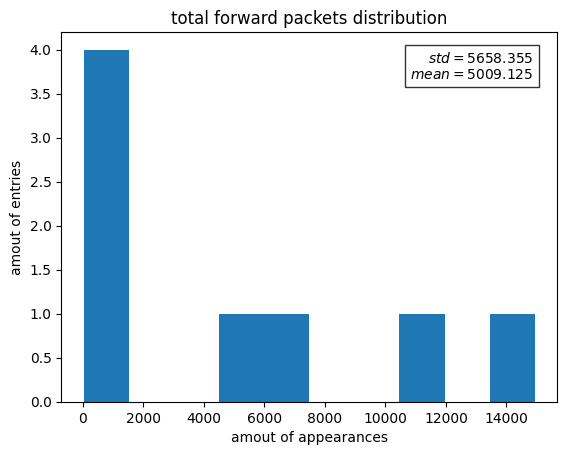

In [ ]:
drawDistributionGraph(data['Tot_Fwd_Pkts'], 'total forward packets')

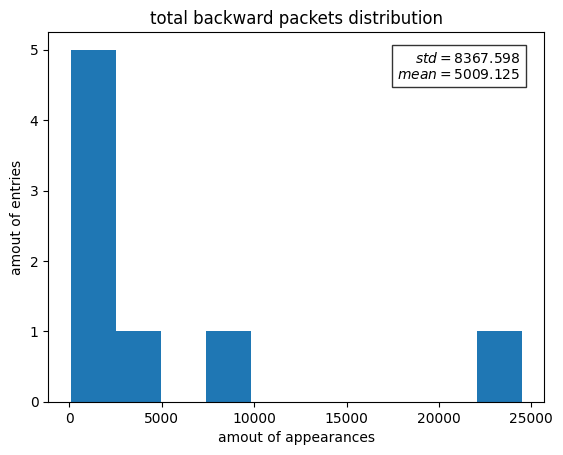

In [ ]:
drawDistributionGraph(data['Tot_Bwd_Pkts'], 'total backward packets')

let check what are the most common src\dst ports

In [ ]:
len(countAppearances(data['Src_Port']))

119

In [ ]:
len(countAppearances(data_all['Src_Port']))

11205

In [ ]:
countAppearances(data['Src_Port']).most_common()

[(9020, 31455),
 (80, 1650),
 (49793, 1424),
 (50966, 1201),
 (49799, 1085),
 (49796, 967),
 (49789, 741),
 (443, 339),
 (57678, 234),
 (54218, 101),
 (42038, 70),
 (37666, 50),
 (42360, 50),
 (5353, 35),
 (52699, 32),
 (35057, 31),
 (0, 28),
 (57210, 28),
 (8281, 23),
 (57217, 22),
 (49362, 20),
 (49360, 20),
 (58382, 16),
 (9010, 13),
 (38073, 12),
 (49791, 11),
 (44675, 10),
 (37518, 10),
 (55017, 10),
 (58383, 10),
 (37714, 10),
 (49787, 9),
 (49366, 9),
 (53354, 8),
 (37516, 8),
 (35410, 7),
 (49797, 7),
 (54442, 7),
 (50866, 7),
 (37512, 7),
 (57219, 7),
 (33760, 7),
 (49794, 7),
 (37092, 6),
 (58727, 6),
 (34007, 6),
 (33685, 6),
 (39486, 6),
 (53692, 6),
 (5223, 6),
 (35104, 6),
 (60498, 6),
 (33782, 6),
 (57221, 6),
 (49788, 6),
 (56401, 6),
 (58102, 6),
 (38127, 6),
 (49792, 5),
 (37747, 5),
 (56625, 5),
 (41716, 5),
 (50059, 5),
 (45638, 5),
 (57215, 5),
 (53642, 5),
 (47527, 5),
 (56359, 5),
 (36294, 5),
 (49795, 5),
 (53177, 4),
 (53648, 4),
 (43457, 4),
 (49798, 4),
 (381

In [ ]:
len(countAppearances(data_all['Dst_Port']))

1034

In [ ]:
len(countAppearances(data['Dst_Port']))

154

In [ ]:
countAppearances(data_all['Dst_Port']).most_common()

[(9020, 114464),
 (10101, 94753),
 (8899, 89518),
 (443, 55358),
 (43238, 46092),
 (554, 43445),
 (49784, 31454),
 (9988, 25125),
 (51875, 23308),
 (19604, 14421),
 (80, 9966),
 (8011, 9057),
 (56196, 7616),
 (0, 6315),
 (52717, 5791),
 (8043, 5412),
 (7100, 4609),
 (7760, 4328),
 (52739, 3681),
 (52704, 3618),
 (7000, 3076),
 (1900, 2762),
 (36762, 1609),
 (9010, 1276),
 (8100, 1083),
 (52942, 981),
 (57894, 900),
 (52330, 652),
 (5353, 602),
 (52919, 597),
 (6500, 578),
 (51298, 480),
 (8080, 445),
 (9664, 384),
 (49375, 345),
 (56211, 312),
 (10000, 306),
 (44144, 301),
 (8281, 297),
 (12616, 294),
 (23, 288),
 (49376, 260),
 (44022, 245),
 (55700, 223),
 (56369, 210),
 (37286, 206),
 (5355, 202),
 (42852, 191),
 (42856, 189),
 (1935, 161),
 (44024, 161),
 (52256, 160),
 (47448, 154),
 (54704, 129),
 (56094, 121),
 (52366, 119),
 (3702, 117),
 (52368, 111),
 (47446, 110),
 (42848, 109),
 (8200, 106),
 (47442, 92),
 (8000, 85),
 (47444, 79),
 (56344, 72),
 (32897, 70),
 (52810, 70),


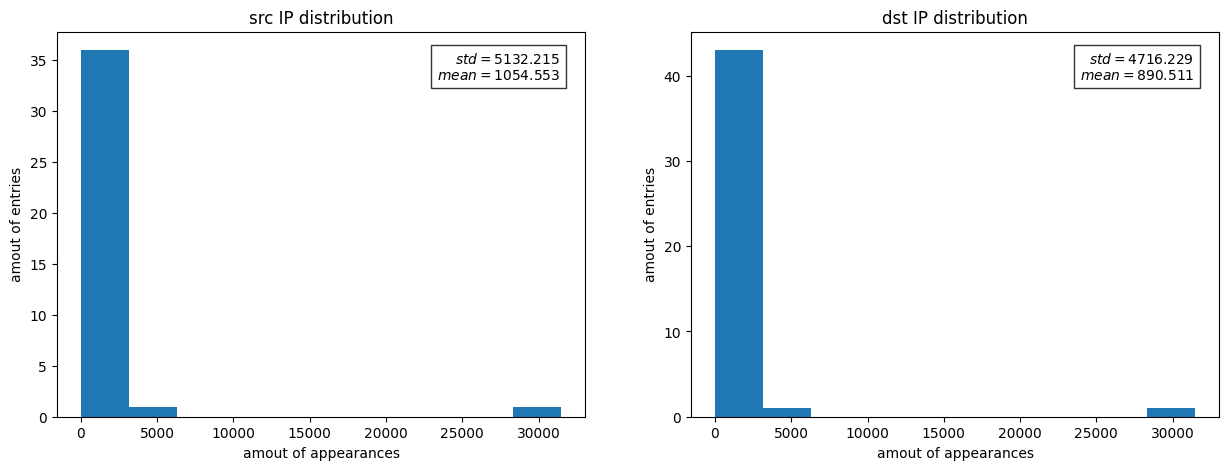

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

plt.subplot(1, 2, 1)
drawDistributionGraph(data['Src_IP'], 'src IP', show=False)
plt.subplot(1, 2, 2)
drawDistributionGraph(data['Dst_IP'], 'dst IP', show=False)
#plt.show()
plt.savefig('IP_Distrib.pdf', format='pdf')

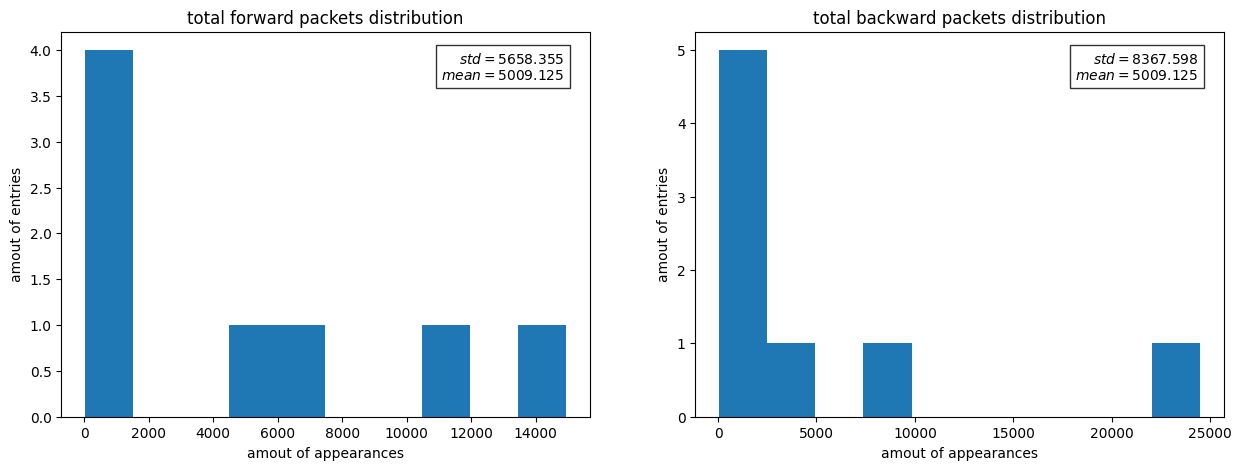

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

plt.subplot(1, 2, 1)
drawDistributionGraph(data['Tot_Fwd_Pkts'], 'total forward packets', show=False)
plt.subplot(1, 2, 2)
drawDistributionGraph(data['Tot_Bwd_Pkts'], 'total backward packets', show=False)
#plt.show()
plt.savefig('Packet_Distrib.pdf', format='pdf')